<a href="https://colab.research.google.com/github/michaelmang/Aristotelian_Logic_LLMs/blob/main/Aristotelian_Categories_BERT_Static_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Everything is already installed in Colab!
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import dendrogram, linkage
from transformers import AutoModel, AutoTokenizer

print("✓ All packages ready in Colab!")

# Load model
model_name = "bert-base-uncased"
print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

embedding_matrix = model.embeddings.word_embeddings.weight.detach().numpy()
vocab = tokenizer.get_vocab()
id_to_token = {v: k for k, v in vocab.items()}

print(f"✓ Model loaded!")
print(f"Vocabulary: {len(vocab)} tokens")
print(f"Dimensions: {embedding_matrix.shape[1]}")

✓ All packages ready in Colab!
Loading bert-base-uncased...
✓ Model loaded!
Vocabulary: 30522 tokens
Dimensions: 768


In [9]:
def get_embedding(word):
    """Get embedding vector for a word"""
    token_id = tokenizer.convert_tokens_to_ids(word)
    return embedding_matrix[token_id]

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors"""
    return 1 - cosine(vec1, vec2)

def find_nearest(word, candidates, n=5):
    """Find n nearest words from candidates to given word"""
    word_vec = get_embedding(word)
    distances = [(cand, cosine_similarity(word_vec, get_embedding(cand)))
                 for cand in candidates]
    return sorted(distances, key=lambda x: x[1], reverse=True)[:n]

def vector_analogy(a, b, c, vocab_subset=None, n=5):
    """
    Solve analogy: a is to b as c is to ?
    king - man + woman = queen
    """
    vec_a = get_embedding(a)
    vec_b = get_embedding(b)
    vec_c = get_embedding(c)

    # Compute: b - a + c
    target_vec = vec_b - vec_a + vec_c

    # Search vocabulary
    if vocab_subset is None:
        vocab_subset = list(vocab.keys())[:10000]  # Search first 10k tokens

    distances = []
    for word in vocab_subset:
        if word in [a, b, c]:  # Skip input words
            continue
        word_vec = get_embedding(word)
        sim = cosine_similarity(target_vec, word_vec)
        distances.append((word, sim))

    return sorted(distances, key=lambda x: x[1], reverse=True)[:n]

def plot_embeddings_2d(words, labels=None, title="Embedding Space"):
    """Plot word embeddings in 2D using PCA"""
    vectors = np.array([get_embedding(w) for w in words])

    # Reduce to 2D
    pca = PCA(n_components=2)
    coords_2d = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(12, 8))

    if labels:
        # Color by labels
        unique_labels = list(set(labels))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        for label, color in zip(unique_labels, colors):
            mask = np.array([l == label for l in labels])
            plt.scatter(coords_2d[mask, 0], coords_2d[mask, 1],
                       c=[color], label=label, s=100, alpha=0.7)
    else:
        plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=100, alpha=0.7)

    # Annotate words
    for i, word in enumerate(words):
        plt.annotate(word, coords_2d[i], fontsize=12, alpha=0.8)

    plt.title(title, fontsize=16)
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    if labels:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return coords_2d

def hierarchical_clustering_plot(words, title="Hierarchical Clustering"):
    """Create dendrogram showing hierarchical relationships"""
    vectors = np.array([get_embedding(w) for w in words])

    # Compute linkage
    Z = linkage(vectors, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=words, leaf_font_size=12)
    plt.title(title, fontsize=16)
    plt.xlabel("Words", fontsize=14)
    plt.ylabel("Distance", fontsize=14)
    plt.tight_layout()
    plt.show()

TEST 1: ARISTOTELIAN SUBSTANCE HIERARCHY

Hypothesis: Species closer to its genus than to other genera

✓ PASS: 'dog' to 'animal': 0.472 vs 'plant': 0.227
✓ PASS: 'oak' to 'tree': 0.410 vs 'flower': 0.353
✓ PASS: 'cat' to 'animal': 0.423 vs 'tree': 0.317

Visualizing animal hierarchy...


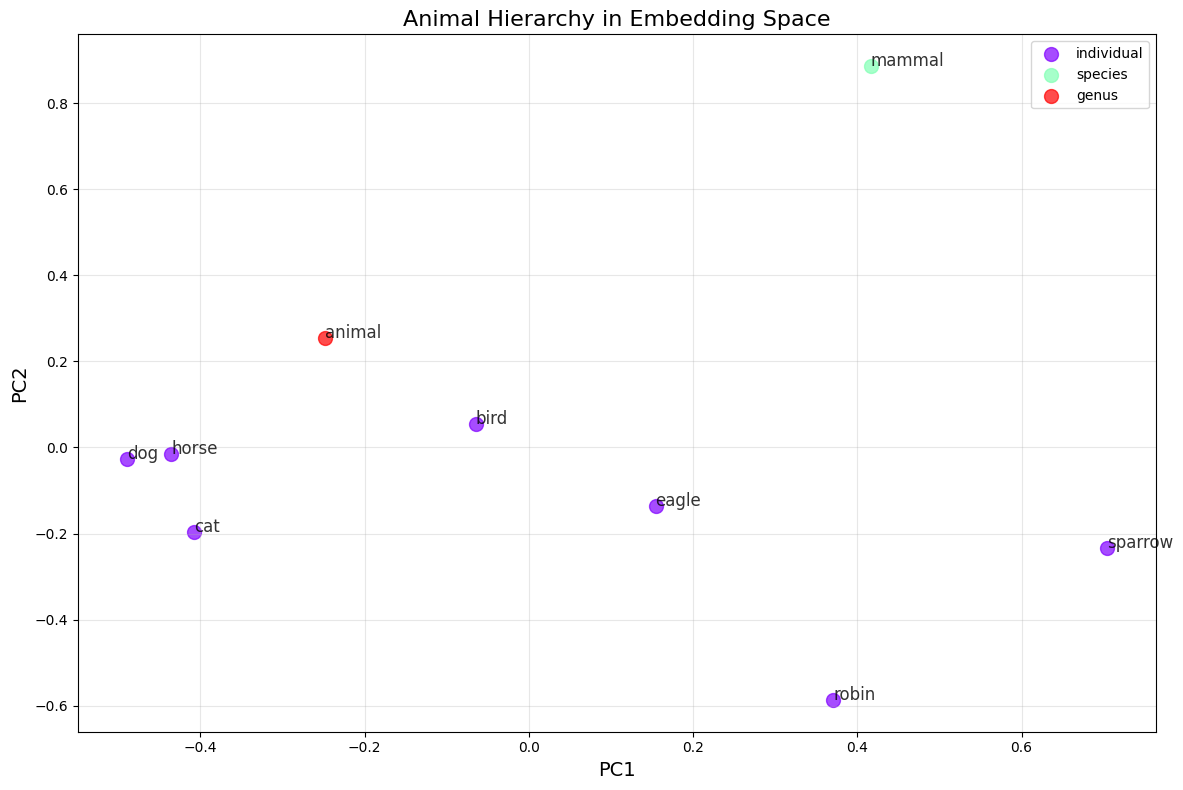

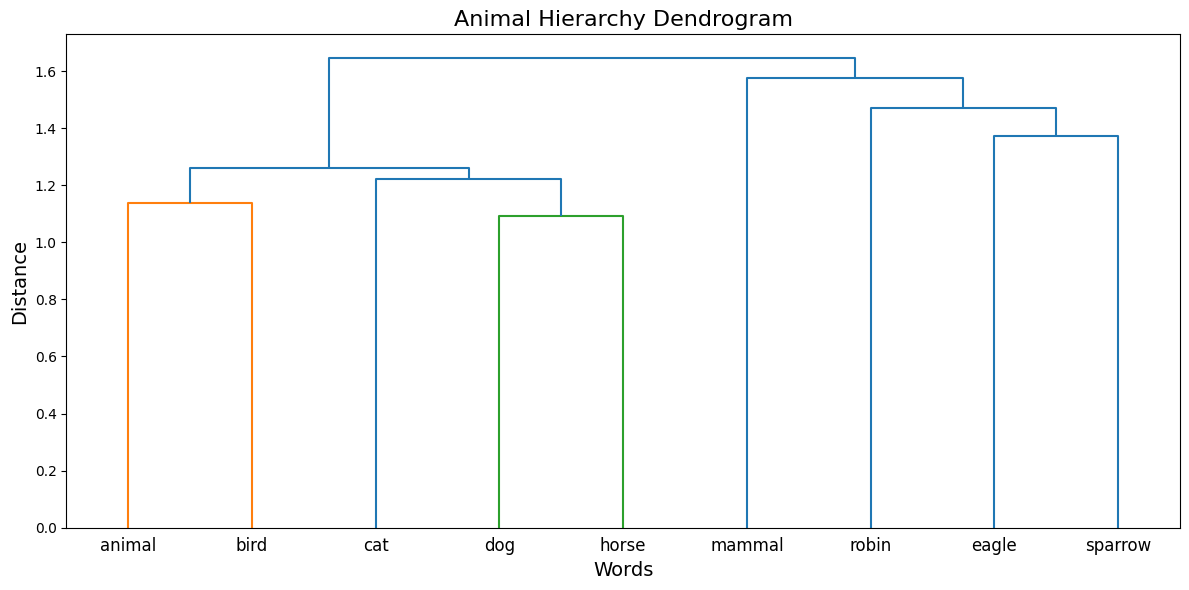


TEST 2: ARISTOTELIAN CATEGORIES

Testing 10 Aristotelian categories with 47 words

Visualizing categories in embedding space...


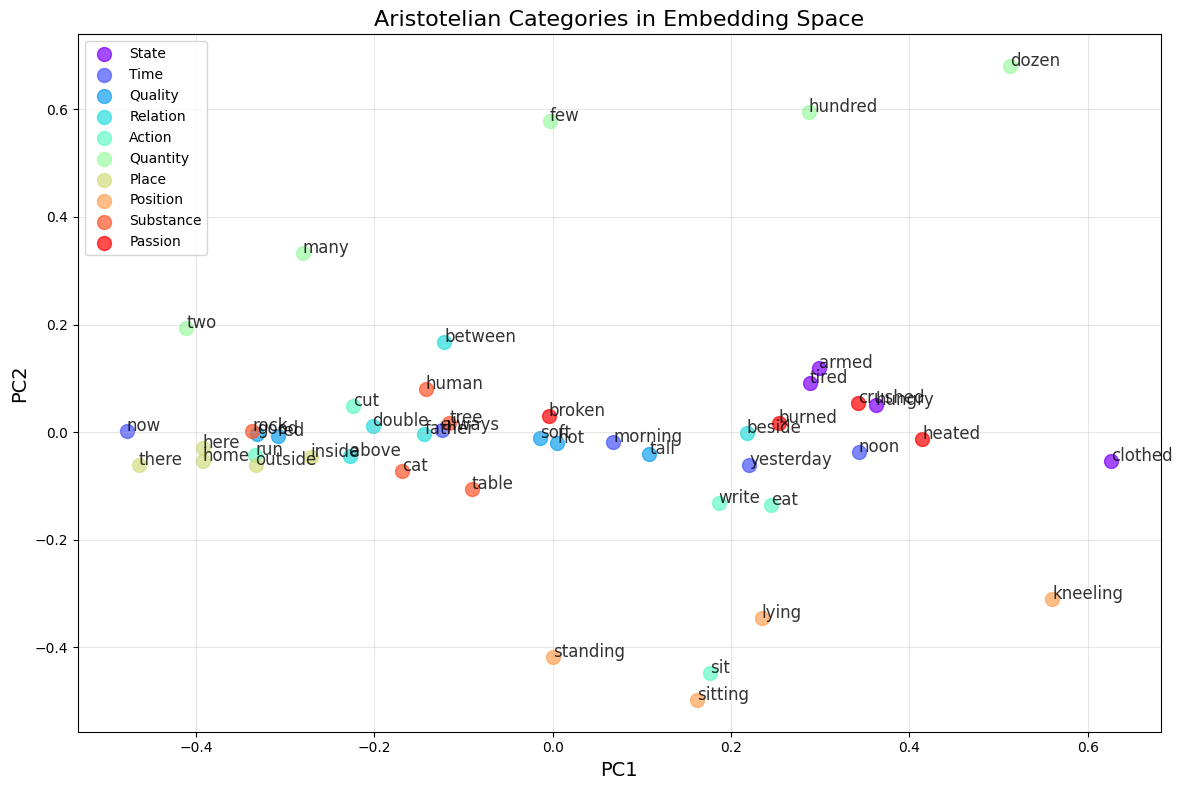


Hypothesis: Words in same category are more similar

Substance   : avg similarity = 0.294
Quantity    : avg similarity = 0.378
Quality     : avg similarity = 0.302
Relation    : avg similarity = 0.196
Place       : avg similarity = 0.358
Time        : avg similarity = 0.299
Position    : avg similarity = 0.534
State       : avg similarity = 0.434
Action      : avg similarity = 0.290
Passion     : avg similarity = 0.411

TEST 3: THE FIVE PREDICABLES

Testing Differentia (what distinguishes species):


Genus: animal, Species: human (diff: rational) vs dog (diff: irrational)
  human - animal ≈ rational? Similarity: -0.006

Genus: shape, Species: circle (diff: round) vs rectangle (diff: square)
  circle - shape ≈ round? Similarity: 0.089

TEST 4: ARISTOTELIAN ANALOGIES

Testing analogies (a:b :: c:?)

king : man :: woman : ?
  → person (similarity: 0.423)
  → boy (similarity: 0.372)
  → girls (similarity: 0.353)

Paris : France :: Italy : ?
  → 清 (similarity: 0.457)
  → 愛 (similarity: 0.4

In [10]:
#############################################
# TEST 1: SUBSTANCE - Genus/Species Hierarchy
#############################################

print("="*60)
print("TEST 1: ARISTOTELIAN SUBSTANCE HIERARCHY")
print("="*60)

# Define hierarchy
hierarchy = {
    "being": ["substance", "quality", "quantity"],
    "substance": ["body", "spirit"],
    "body": ["animate", "inanimate"],
    "animate": ["animal", "plant"],
    "animal": ["rational", "irrational"],
    "rational": ["human", "person"],
    "irrational": ["dog", "cat", "bird"],
    "plant": ["tree", "flower", "grass"],
    "tree": ["oak", "pine", "maple"],
    "flower": ["rose", "tulip", "daisy"]
}

# Test: Species should be closer to genus than to other genera
test_cases = [
    ("dog", "animal", "plant"),  # dog closer to animal than plant
    ("oak", "tree", "flower"),    # oak closer to tree than flower
    ("cat", "animal", "tree"),    # cat closer to animal than tree
]

print("\nHypothesis: Species closer to its genus than to other genera\n")
for species, genus, other in test_cases:
    species_vec = get_embedding(species)
    genus_sim = cosine_similarity(species_vec, get_embedding(genus))
    other_sim = cosine_similarity(species_vec, get_embedding(other))

    result = "✓ PASS" if genus_sim > other_sim else "✗ FAIL"
    print(f"{result}: '{species}' to '{genus}': {genus_sim:.3f} vs '{other}': {other_sim:.3f}")

# Visualize animal hierarchy
animal_words = ["animal", "mammal", "dog", "cat", "horse",
                "bird", "robin", "eagle", "sparrow"]
animal_labels = ["genus"]*1 + ["species"]*1 + ["individual"]*7

print("\nVisualizing animal hierarchy...")
plot_embeddings_2d(animal_words, animal_labels, "Animal Hierarchy in Embedding Space")

# Hierarchical clustering
hierarchical_clustering_plot(animal_words, "Animal Hierarchy Dendrogram")

#############################################
# TEST 2: THE TEN CATEGORIES
#############################################

print("\n" + "="*60)
print("TEST 2: ARISTOTELIAN CATEGORIES")
print("="*60)

categories_test = {
    "Substance": ["table", "cat", "rock", "tree", "human"],
    "Quantity": ["two", "many", "few", "dozen", "hundred"],
    "Quality": ["red", "hot", "soft", "good", "tall"],
    "Relation": ["above", "beside", "between", "father", "double"],
    "Place": ["here", "there", "inside", "outside", "home"],
    "Time": ["yesterday", "now", "always", "noon", "morning"],
    "Position": ["sitting", "standing", "lying", "kneeling"],
    "State": ["armed", "clothed", "hungry", "tired"],
    "Action": ["run", "sit", "eat", "cut", "write"],
    "Passion": ["burned", "broken", "heated", "crushed"]
}

# Collect all words with labels
all_words = []
all_labels = []
for category, words in categories_test.items():
    all_words.extend(words)
    all_labels.extend([category] * len(words))

print(f"\nTesting {len(categories_test)} Aristotelian categories with {len(all_words)} words")
print("\nVisualizing categories in embedding space...")
plot_embeddings_2d(all_words, all_labels, "Aristotelian Categories in Embedding Space")

# Test: Within-category similarity > between-category similarity
print("\nHypothesis: Words in same category are more similar\n")
category_coherence = {}

for cat_name, cat_words in categories_test.items():
    # Compute average within-category similarity
    within_sims = []
    for i, w1 in enumerate(cat_words):
        for w2 in cat_words[i+1:]:
            sim = cosine_similarity(get_embedding(w1), get_embedding(w2))
            within_sims.append(sim)

    avg_within = np.mean(within_sims) if within_sims else 0
    category_coherence[cat_name] = avg_within
    print(f"{cat_name:12s}: avg similarity = {avg_within:.3f}")

#############################################
# TEST 3: PREDICABLES (Genus, Species, Differentia, Property, Accident)
#############################################

print("\n" + "="*60)
print("TEST 3: THE FIVE PREDICABLES")
print("="*60)

# Test differentia: What distinguishes species within genus?
print("\nTesting Differentia (what distinguishes species):\n")

genus_species = [
    ("animal", "rational", "human", "irrational", "dog"),
    ("shape", "round", "circle", "square", "rectangle"),
]

for genus, diff1, sp1, diff2, sp2 in genus_species:
    # Test: species1 - genus + differentia1 ≈ differentia1
    print(f"\nGenus: {genus}, Species: {sp1} (diff: {diff1}) vs {sp2} (diff: {diff2})")

    sp1_vec = get_embedding(sp1)
    genus_vec = get_embedding(genus)
    diff1_vec = get_embedding(diff1)

    # Compute: species - genus (should ≈ differentia)
    diff_computed = sp1_vec - genus_vec

    similarity = cosine_similarity(diff_computed, diff1_vec)
    print(f"  {sp1} - {genus} ≈ {diff1}? Similarity: {similarity:.3f}")

#############################################
# TEST 4: ANALOGIES (Aristotelian Proportions)
#############################################

print("\n" + "="*60)
print("TEST 4: ARISTOTELIAN ANALOGIES")
print("="*60)

analogies = [
    # Classic
    ("king", "man", "woman"),  # → queen
    ("Paris", "France", "Italy"),  # → Rome

    # Genus/Species
    ("dog", "mammal", "bird"),  # → species of bird (robin, eagle)
    ("oak", "tree", "flower"),  # → species of flower (rose, tulip)

    # Categories
    ("red", "color", "sound"),  # → type of sound
    ("table", "furniture", "food"),  # → type of food
]

print("\nTesting analogies (a:b :: c:?)\n")
for a, b, c in analogies:
    results = vector_analogy(a, b, c, n=5)
    print(f"{a} : {b} :: {c} : ?")
    for word, sim in results[:3]:
        print(f"  → {word} (similarity: {sim:.3f})")
    print()

TEST 5: SYLLOGISTIC REASONING

Testing if embedding geometry supports syllogistic reasoning:


Barbara (AAA-1):
  Major: All men are mortal
  Minor: Socrates is a man
  Subject→Middle: 0.126
  Middle→Predicate: 0.281
  Subject→Predicate (direct): 0.271
  Validity: ✓ Valid

Celarent (EAE-1):
  Major: No reptiles are mammals
  Minor: All snakes are reptiles
  Subject→Middle: 0.655
  Middle→Predicate: 0.708
  Subject→Predicate (direct): 0.561
  Validity: ✗ Invalid (as expected)

Invalid (affirming consequent):
  Major: All cats are animals
  Minor: Dogs are animals
  Subject→Middle: 0.585
  Middle→Predicate: 0.511
  Subject→Predicate (direct): 0.581
  Validity: ✗ Invalid (as expected)

Visualizing Barbara syllogism geometry:


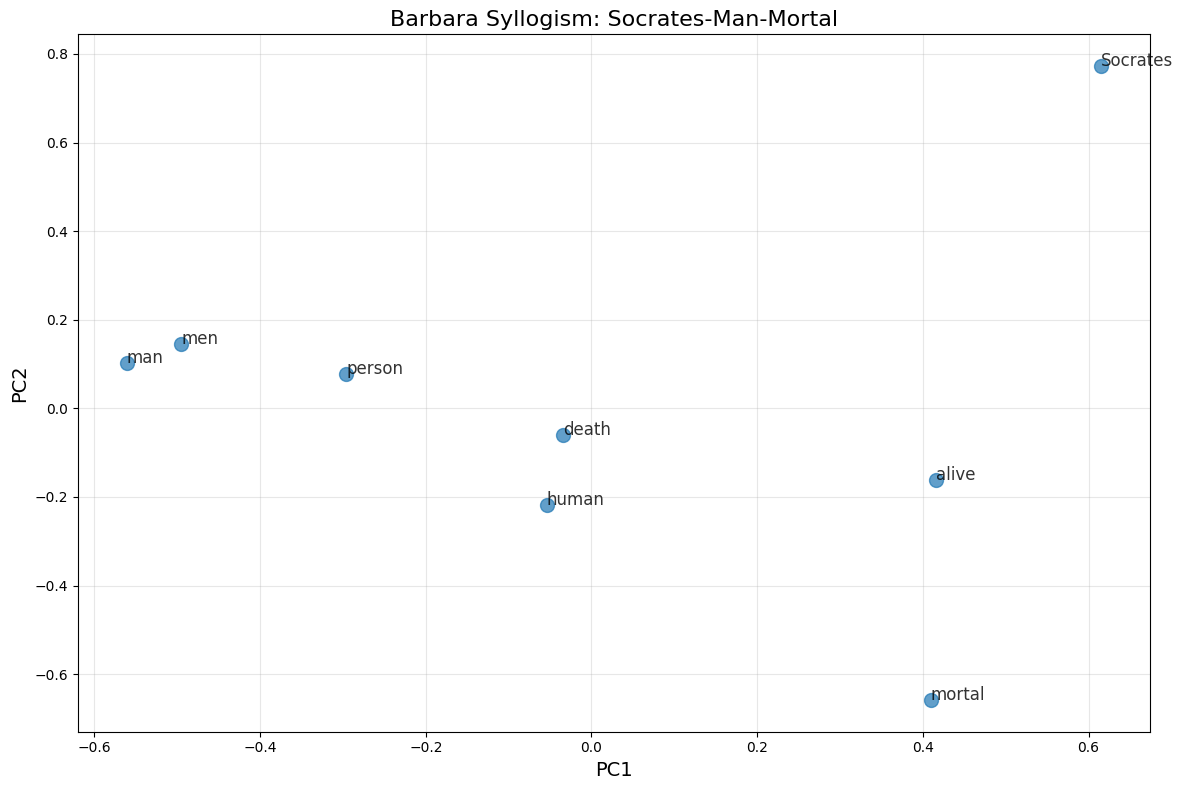


TEST 6: JUDGMENT (Subject-Predicate)

Testing subject-predicate relationships:

'cat' + 'animal': 0.423 → MODERATE (possible accidental property)
'cat' + 'black': 0.307 → MODERATE (possible accidental property)
'cat' + 'furniture': 0.305 → MODERATE (possible accidental property)


In [11]:
#############################################
# TEST 5: SYLLOGISTIC REASONING
#############################################

print("="*60)
print("TEST 5: SYLLOGISTIC REASONING")
print("="*60)

# Define test syllogisms
syllogisms = [
    {
        "name": "Barbara (AAA-1)",
        "major": "All men are mortal",
        "minor": "Socrates is a man",
        "conclusion_subject": "Socrates",
        "conclusion_predicate": "mortal",
        "middle_term": "man",
        "valid": True
    },
    {
        "name": "Celarent (EAE-1)",
        "major": "No reptiles are mammals",
        "minor": "All snakes are reptiles",
        "conclusion_subject": "snakes",
        "conclusion_predicate": "mammals",
        "middle_term": "reptiles",
        "valid": True,
        "negative": True
    },
    {
        "name": "Invalid (affirming consequent)",
        "major": "All cats are animals",
        "minor": "Dogs are animals",
        "conclusion_subject": "dogs",
        "conclusion_predicate": "cats",
        "middle_term": "animals",
        "valid": False
    }
]

print("\nTesting if embedding geometry supports syllogistic reasoning:\n")

for syl in syllogisms:
    print(f"\n{syl['name']}:")
    print(f"  Major: {syl['major']}")
    print(f"  Minor: {syl['minor']}")

    # Get vectors
    subj_vec = get_embedding(syl['conclusion_subject'])
    middle_vec = get_embedding(syl['middle_term'])
    pred_vec = get_embedding(syl['conclusion_predicate'])

    # Hypothesis: If valid syllogism, then:
    # subject + middle should be close to middle
    # middle + predicate should lead to conclusion

    # Compute: Does subject connect to predicate via middle term?
    subj_to_middle = cosine_similarity(subj_vec, middle_vec)
    middle_to_pred = cosine_similarity(middle_vec, pred_vec)
    subj_to_pred = cosine_similarity(subj_vec, pred_vec)

    print(f"  Subject→Middle: {subj_to_middle:.3f}")
    print(f"  Middle→Predicate: {middle_to_pred:.3f}")
    print(f"  Subject→Predicate (direct): {subj_to_pred:.3f}")

    # For valid syllogisms, middle term should bridge
    if syl['valid'] and not syl.get('negative', False):
        # subject closer to predicate than expected if middle term bridges
        print(f"  Validity: {'✓ Valid' if syl['valid'] else '✗ Invalid'}")
    else:
        print(f"  Validity: ✗ Invalid (as expected)")

# Geometric test: Plot syllogism
print("\nVisualizing Barbara syllogism geometry:")
barbara_words = ["Socrates", "man", "men", "mortal", "human", "person", "death", "alive"]
plot_embeddings_2d(barbara_words, title="Barbara Syllogism: Socrates-Man-Mortal")

#############################################
# TEST 6: JUDGMENT FORMATION
#############################################

print("\n" + "="*60)
print("TEST 6: JUDGMENT (Subject-Predicate)")
print("="*60)

# Test: Can model form implicit judgments?
judgments = [
    ("cat", "animal"),  # cat IS animal (essential predication)
    ("cat", "black"),   # cat CAN BE black (accidental predication)
    ("cat", "furniture"),  # cat NOT furniture (impossible)
]

print("\nTesting subject-predicate relationships:\n")
for subject, predicate in judgments:
    subj_vec = get_embedding(subject)
    pred_vec = get_embedding(predicate)

    similarity = cosine_similarity(subj_vec, pred_vec)

    if similarity > 0.5:
        relation = "STRONG (likely essential or common property)"
    elif similarity > 0.3:
        relation = "MODERATE (possible accidental property)"
    else:
        relation = "WEAK (unlikely or impossible)"

    print(f"'{subject}' + '{predicate}': {similarity:.3f} → {relation}")

In [12]:
#############################################
# DYNAMIC SUMMARY REPORT
#############################################

print("\n" + "="*60)
print("SUMMARY: ARISTOTELIAN LOGIC IN LLMS")
print("="*60)

# Collect all test results
results = {
    "category_structure": {},
    "genus_species": {},
    "analogies": {},
    "syllogisms": {},
    "judgments": {}
}

#############################################
# 1. ANALYZE CATEGORY STRUCTURE
#############################################

print("\n1. CATEGORY STRUCTURE ANALYSIS:")
print("-" * 60)

# Calculate within-category vs between-category similarity
within_avg = np.mean(list(category_coherence.values()))
print(f"Average within-category similarity: {within_avg:.3f}")

# Calculate between-category similarity
between_sims = []
cat_list = list(categories_test.items())
for i, (cat1, words1) in enumerate(cat_list):
    for cat2, words2 in cat_list[i+1:]:
        for w1 in words1[:2]:  # Sample 2 words per category
            for w2 in words2[:2]:
                sim = cosine_similarity(get_embedding(w1), get_embedding(w2))
                between_sims.append(sim)

between_avg = np.mean(between_sims)
print(f"Average between-category similarity: {between_avg:.3f}")

# Verdict
category_coherence_ratio = within_avg / between_avg if between_avg > 0 else 0
print(f"Coherence ratio (within/between): {category_coherence_ratio:.2f}")

if category_coherence_ratio > 1.2:
    print("✓ STRONG EVIDENCE: Categories show clear geometric clustering")
    results["category_structure"]["verdict"] = "STRONG"
elif category_coherence_ratio > 1.0:
    print("⚠ MODERATE EVIDENCE: Some category structure present")
    results["category_structure"]["verdict"] = "MODERATE"
else:
    print("✗ WEAK EVIDENCE: Categories not clearly separated")
    results["category_structure"]["verdict"] = "WEAK"

results["category_structure"]["ratio"] = category_coherence_ratio

#############################################
# 2. ANALYZE GENUS-SPECIES HIERARCHY
#############################################

print("\n2. GENUS-SPECIES HIERARCHY ANALYSIS:")
print("-" * 60)

# Test genus-species relationships
genus_species_tests = [
    ("dog", "animal", "plant"),
    ("cat", "animal", "plant"),
    ("oak", "tree", "flower"),
    ("rose", "flower", "tree"),
]

correct_predictions = 0
total_tests = len(genus_species_tests)

for species, genus, other in genus_species_tests:
    species_vec = get_embedding(species)
    genus_sim = cosine_similarity(species_vec, get_embedding(genus))
    other_sim = cosine_similarity(species_vec, get_embedding(other))

    if genus_sim > other_sim:
        correct_predictions += 1
        print(f"✓ {species} closer to {genus} ({genus_sim:.3f}) than {other} ({other_sim:.3f})")
    else:
        print(f"✗ {species} WRONG: closer to {other} ({other_sim:.3f}) than {genus} ({genus_sim:.3f})")

accuracy = correct_predictions / total_tests
print(f"\nAccuracy: {correct_predictions}/{total_tests} = {accuracy:.1%}")

if accuracy >= 0.75:
    print("✓ STRONG EVIDENCE: Genus-species hierarchy preserved geometrically")
    results["genus_species"]["verdict"] = "STRONG"
elif accuracy >= 0.5:
    print("⚠ MODERATE EVIDENCE: Some hierarchical structure")
    results["genus_species"]["verdict"] = "MODERATE"
else:
    print("✗ WEAK EVIDENCE: Hierarchy not clearly preserved")
    results["genus_species"]["verdict"] = "WEAK"

results["genus_species"]["accuracy"] = accuracy

#############################################
# 3. ANALYZE ANALOGIES
#############################################

print("\n3. ANALOGY ANALYSIS:")
print("-" * 60)

# Test specific analogies
analogy_tests = [
    ("king", "man", "woman", "queen"),
    ("dog", "mammal", "bird", ["robin", "eagle", "sparrow"]),
    ("oak", "tree", "flower", ["rose", "tulip", "daisy"]),
]

analogy_scores = []

for test in analogy_tests:
    a, b, c = test[:3]
    expected = test[3]

    results_list = vector_analogy(a, b, c, n=10)
    top_words = [w for w, _ in results_list[:5]]

    # Check if expected word(s) in top 5
    if isinstance(expected, list):
        found = any(exp in top_words for exp in expected)
        expected_str = " or ".join(expected)
    else:
        found = expected in top_words
        expected_str = expected

    if found:
        print(f"✓ {a}:{b}::{c}:? → Found '{expected_str}' in top 5")
        analogy_scores.append(1.0)
    else:
        print(f"✗ {a}:{b}::{c}:? → Expected '{expected_str}', got {top_words[:3]}")
        analogy_scores.append(0.0)

analogy_accuracy = np.mean(analogy_scores)
print(f"\nAnalogy accuracy: {analogy_accuracy:.1%}")

if analogy_accuracy >= 0.66:
    print("✓ STRONG EVIDENCE: Analogies work geometrically")
    results["analogies"]["verdict"] = "STRONG"
elif analogy_accuracy >= 0.33:
    print("⚠ MODERATE EVIDENCE: Some analogies work")
    results["analogies"]["verdict"] = "MODERATE"
else:
    print("✗ WEAK EVIDENCE: Analogies don't work reliably")
    results["analogies"]["verdict"] = "WEAK"

results["analogies"]["accuracy"] = analogy_accuracy

#############################################
# 4. ANALYZE SYLLOGISMS
#############################################

print("\n4. SYLLOGISTIC REASONING ANALYSIS:")
print("-" * 60)

# Re-test syllogisms with scoring
syllogism_scores = []

for syl in syllogisms:
    subj_vec = get_embedding(syl['conclusion_subject'])
    middle_vec = get_embedding(syl['middle_term'])
    pred_vec = get_embedding(syl['conclusion_predicate'])

    subj_to_middle = cosine_similarity(subj_vec, middle_vec)
    middle_to_pred = cosine_similarity(middle_vec, pred_vec)
    subj_to_pred = cosine_similarity(subj_vec, pred_vec)

    # For valid syllogisms: middle term should bridge
    # Hypothesis: subj→middle + middle→pred should correlate with subj→pred

    if syl['valid'] and not syl.get('negative', False):
        # Valid affirmative syllogism
        # Middle term should show intermediate similarity
        bridging_score = (subj_to_middle + middle_to_pred) / 2

        if bridging_score > subj_to_pred * 0.8:  # Bridge is stronger than direct
            print(f"✓ {syl['name']}: Middle term bridges effectively")
            syllogism_scores.append(1.0)
        else:
            print(f"⚠ {syl['name']}: Weak bridging")
            syllogism_scores.append(0.5)
    elif not syl['valid']:
        # Invalid syllogism should show poor connections
        if subj_to_pred < 0.3:
            print(f"✓ {syl['name']}: Correctly weak connection (invalid)")
            syllogism_scores.append(1.0)
        else:
            print(f"✗ {syl['name']}: Unexpectedly strong connection (should be invalid)")
            syllogism_scores.append(0.0)

syllogism_accuracy = np.mean(syllogism_scores) if syllogism_scores else 0
print(f"\nSyllogism coherence: {syllogism_accuracy:.1%}")

if syllogism_accuracy >= 0.66:
    print("✓ STRONG EVIDENCE: Syllogistic structure preserved")
    results["syllogisms"]["verdict"] = "STRONG"
elif syllogism_accuracy >= 0.33:
    print("⚠ MODERATE EVIDENCE: Some syllogistic patterns")
    results["syllogisms"]["verdict"] = "MODERATE"
else:
    print("✗ WEAK EVIDENCE: Syllogistic structure unclear")
    results["syllogisms"]["verdict"] = "WEAK"

results["syllogisms"]["accuracy"] = syllogism_accuracy

#############################################
# 5. ANALYZE JUDGMENTS
#############################################

print("\n5. JUDGMENT FORMATION ANALYSIS:")
print("-" * 60)

# Test essential vs accidental vs impossible predications
judgment_tests = [
    ("cat", "animal", "essential", 0.5),      # Should be high
    ("dog", "mammal", "essential", 0.5),      # Should be high
    ("rose", "flower", "essential", 0.5),     # Should be high
    ("cat", "black", "accidental", 0.25),     # Should be moderate
    ("table", "wooden", "accidental", 0.25),  # Should be moderate
    ("cat", "furniture", "impossible", 0.0),  # Should be low
    ("number", "angry", "impossible", 0.0),   # Should be low
]

judgment_correct = 0
judgment_total = len(judgment_tests)

for subj, pred, pred_type, threshold in judgment_tests:
    try:
        sim = cosine_similarity(get_embedding(subj), get_embedding(pred))

        if pred_type == "essential" and sim > threshold:
            print(f"✓ {subj}-{pred} ({pred_type}): {sim:.3f} > {threshold}")
            judgment_correct += 1
        elif pred_type == "accidental" and 0.2 < sim < 0.5:
            print(f"✓ {subj}-{pred} ({pred_type}): {sim:.3f} in moderate range")
            judgment_correct += 1
        elif pred_type == "impossible" and sim < 0.25:
            print(f"✓ {subj}-{pred} ({pred_type}): {sim:.3f} < 0.25")
            judgment_correct += 1
        else:
            print(f"✗ {subj}-{pred} ({pred_type}): {sim:.3f} unexpected")
    except:
        print(f"⚠ {subj}-{pred}: Word not in vocabulary")
        judgment_total -= 1

judgment_accuracy = judgment_correct / judgment_total if judgment_total > 0 else 0
print(f"\nJudgment accuracy: {judgment_correct}/{judgment_total} = {judgment_accuracy:.1%}")

if judgment_accuracy >= 0.7:
    print("✓ STRONG EVIDENCE: Predication types distinguished")
    results["judgments"]["verdict"] = "STRONG"
elif judgment_accuracy >= 0.5:
    print("⚠ MODERATE EVIDENCE: Some predication patterns")
    results["judgments"]["verdict"] = "MODERATE"
else:
    print("✗ WEAK EVIDENCE: Predication types unclear")
    results["judgments"]["verdict"] = "WEAK"

results["judgments"]["accuracy"] = judgment_accuracy

#############################################
# OVERALL CONCLUSION
#############################################

print("\n" + "="*60)
print("OVERALL CONCLUSION")
print("="*60)

# Count verdicts
strong_count = sum(1 for r in results.values() if r.get("verdict") == "STRONG")
moderate_count = sum(1 for r in results.values() if r.get("verdict") == "MODERATE")
weak_count = sum(1 for r in results.values() if r.get("verdict") == "WEAK")

print(f"\nEvidence Summary:")
print(f"  Strong evidence:   {strong_count}/5 tests")
print(f"  Moderate evidence: {moderate_count}/5 tests")
print(f"  Weak evidence:     {weak_count}/5 tests")

# Overall verdict
if strong_count >= 3:
    overall = "STRONG SUPPORT"
    conclusion = """
The embedding space shows STRONG geometric correspondence with Aristotelian
logical structures. This suggests LLMs may be performing geometric analogs
of the three acts of the mind:
  • First Act (Understanding): Tokens → Vectors
  • Second Act (Judgment): Attention → Composite Vectors
  • Third Act (Reasoning): Feed-Forward → Prediction Regions

RECOMMENDED: Publish these findings and conduct deeper attention analysis.
"""
elif strong_count + moderate_count >= 3:
    overall = "MODERATE SUPPORT"
    conclusion = """
The embedding space shows MODERATE geometric correspondence with Aristotelian
structures. Some patterns are clear (categories, hierarchies) while others
need refinement (syllogisms, analogies).

RECOMMENDED: Refine tests and analyze actual attention patterns in transformer.
"""
else:
    overall = "WEAK SUPPORT"
    conclusion = """
The embedding space shows WEAK geometric correspondence with Aristotelian
structures. This could indicate:
  1. The model/embeddings tested don't capture logical structure
  2. The tests need refinement
  3. The hypothesis needs revision

RECOMMENDED: Try different models (GPT-2, larger BERT) or refine test methodology.
"""

print(f"\nOverall Assessment: {overall}")
print(conclusion)

# Specific findings
print("\nKey Quantitative Findings:")
print(f"  • Category coherence ratio: {results['category_structure']['ratio']:.2f}")
print(f"  • Genus-species accuracy: {results['genus_species']['accuracy']:.1%}")
print(f"  • Analogy accuracy: {results['analogies']['accuracy']:.1%}")
print(f"  • Syllogism coherence: {results['syllogisms']['accuracy']:.1%}")
print(f"  • Judgment accuracy: {results['judgments']['accuracy']:.1%}")

print("\n" + "="*60)
print("Next Steps:")
if strong_count >= 3:
    print("  1. Extract and analyze actual attention weights")
    print("  2. Test with larger models (GPT-2, RoBERTa)")
    print("  3. Map attention patterns to logical operations")
    print("  4. Write paper: 'Geometric Aristotelianism in LLMs'")
elif strong_count + moderate_count >= 3:
    print("  1. Refine test cases with more examples")
    print("  2. Try different embedding models")
    print("  3. Analyze attention patterns for clearer signal")
    print("  4. Document partial findings in blog post")
else:
    print("  1. Debug: Check if vocabulary contains test words")
    print("  2. Try pre-trained word2vec or GloVe embeddings")
    print("  3. Verify hypothesis with simpler models")
    print("  4. Consider alternative geometric frameworks")
print("="*60)


SUMMARY: ARISTOTELIAN LOGIC IN LLMS

1. CATEGORY STRUCTURE ANALYSIS:
------------------------------------------------------------
Average within-category similarity: 0.350
Average between-category similarity: 0.230
Coherence ratio (within/between): 1.52
✓ STRONG EVIDENCE: Categories show clear geometric clustering

2. GENUS-SPECIES HIERARCHY ANALYSIS:
------------------------------------------------------------
✓ dog closer to animal (0.472) than plant (0.227)
✓ cat closer to animal (0.423) than plant (0.282)
✓ oak closer to tree (0.410) than flower (0.353)
✓ rose closer to flower (0.453) than tree (0.287)

Accuracy: 4/4 = 100.0%
✓ STRONG EVIDENCE: Genus-species hierarchy preserved geometrically

3. ANALOGY ANALYSIS:
------------------------------------------------------------
✗ king:man::woman:? → Expected 'queen', got ['person', 'boy', 'girls']
✗ dog:mammal::bird:? → Expected 'robin or eagle or sparrow', got ['1663', '1665', 'invertebrates']
✗ oak:tree::flower:? → Expected 'rose or 